In [14]:
import pandas as pd
import numpy as np
import scipy as sp 

from sklearn import preprocessing, linear_model
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt

In [2]:
# The Data from : https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

# The data path of input file
data_path = "./dota2Test.csv"
data_path2 = "./dota2Train.csv"

# Read csv file to pandas dataframe
pd_data = pd.read_csv(data_path)
pd_data2 = pd.read_csv(data_path2)

In [3]:
pd_data.head()

,win,place,mode,type,heroStart,hero2,q,a,z,2,...,mmm,iii,kkk,",,,",ooo,lll,…,ppp,;;;,///
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 每列都是一個單獨的遊戲對局 且每一欄分別代表以下的特徵
1. 贏或是輸（1 或 -1）
2. 玩家區域id
3. 遊戲模式（例如 all pick） 
4. 遊戲種類（例如 積分）
5. 直到最後一欄，每個element都是代表一個英雄
    * value=1 代表 代號1隊伍(也就是獲勝隊伍)是用這隻英雄 
    * -1則反之
    * 每個英雄只可被一個玩家選中（含兩隊）。代表每行都有五個1和-1。  

In [4]:
import json
# 读取数据
hero_realname=[]
with open('hero.json', 'r') as f:
    js_data = json.load(f)
    for i in js_data['heroes']:
        #print(i['localized_name'])
        hero_realname.append(i['localized_name'])

# correlation

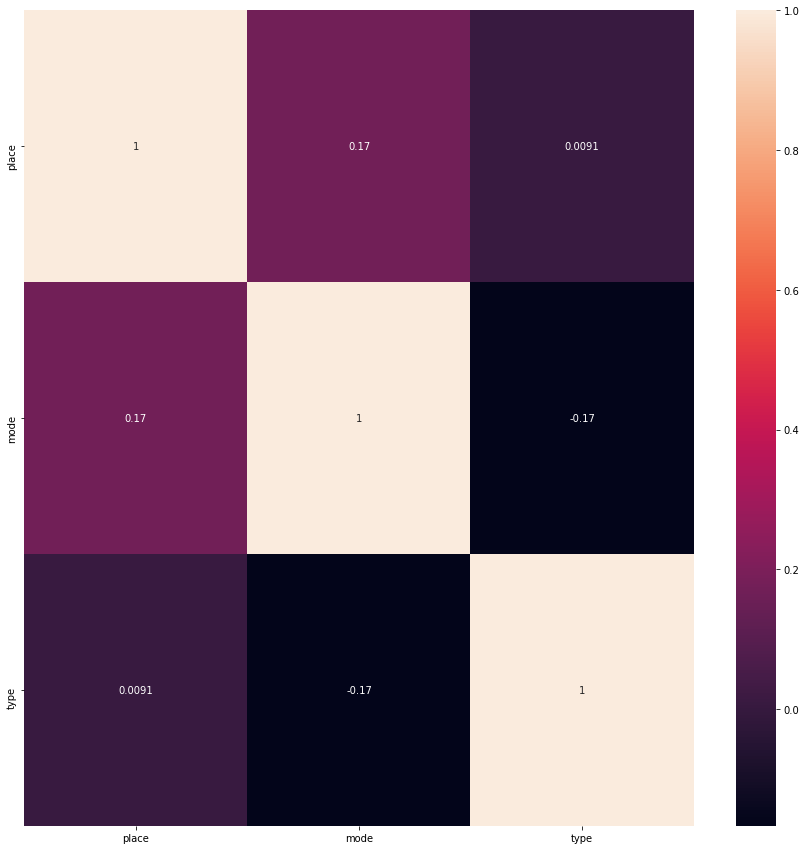

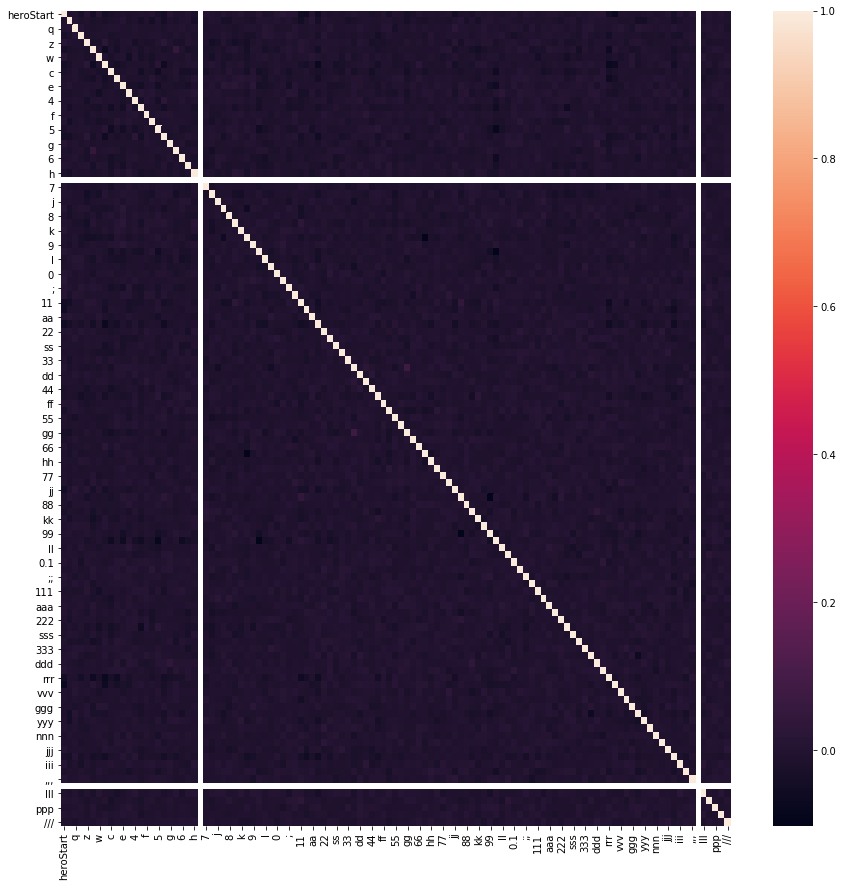

In [5]:
import seaborn as sns
plt.figure(figsize=(15,15))
foo1 = sns.heatmap(pd_data.iloc[:,[1,2,3]].corr(),annot=True)
plt.figure(figsize=(15,15))
foo2 = sns.heatmap(pd_data.iloc[:,4:].corr())

### 分兩類attribute做相關係數
* 0,1,2,3 column 
* 4~最後一個colum
* 發現相關係數都不高
推測因為 dota 遊戲是多人遊戲，若對單一英雄去做相關係數分析本來就不會準確

In [6]:
win_lose = pd_data['win']
place_id = pd_data['place']
game_mode = pd_data['mode']
game_type = pd_data['type']
pd_data = pd_data.drop(['place', 'mode', 'type'], axis=1)
print('只留下勝負和英雄使用的欄位')
pd_data.head()

只留下勝負和英雄使用的欄位


,win,heroStart,hero2,q,a,z,2,w,s,c,...,mmm,iii,kkk,",,,",ooo,lll,…,ppp,;;;,///
0,-1,0,-1,0,0,0,0,0,0,1,...,-1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,-1,0,0,0,0,0,0,0,0,0
2,-1,1,0,0,0,-1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,-1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,-1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0


# statistics

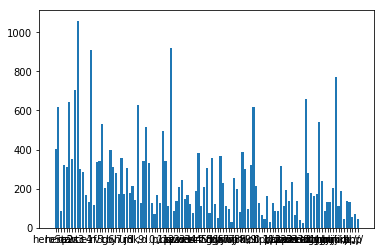

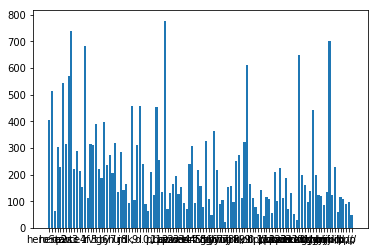

In [7]:
# find all heros col name
col_title = []
for col in pd_data.columns: 
    col_title.append(col)
col_title.remove(col_title[0])

# 計算出每個英雄使用的時候，贏得場次數目
hero_win = {}
hero_lose = {}
for i in col_title:
    current_hero_name = i
    current_hero_use_list = pd_data[current_hero_name].values.tolist()
    for j in range(0, len(current_hero_use_list)):
        if current_hero_use_list[j]==1:
            if win_lose[j]==1:
                if current_hero_name in hero_win:
                    hero_win[current_hero_name]+=1
                else:
                    hero_win[current_hero_name]=1
            elif win_lose[j]==-1:
                if current_hero_name in hero_lose:
                    hero_lose[current_hero_name]+=1
                else:
                    hero_lose[current_hero_name]=1
plt.bar(range(len(hero_win)), list(hero_win.values()), align='center')
plt.xticks(range(len(hero_win)), list(hero_win.keys()))
plt.show()
plt.bar(range(len(hero_lose)), list(hero_lose.values()), align='center')
plt.xticks(range(len(hero_lose)), list(hero_lose.keys()))
plt.show()

### 每個英雄的使用時的勝負狀況
* 因為 x 軸的英雄在上下兩圖都是一樣的對應，所以可以看出明顯有些熱門英雄經常被選到
    * 透過長條狀的線幾乎都發生在相近的位置可看出
* 不過經常被選到贏的次數固然提高了，但是輸的次數也不少

# Logistic Regression 預測該場比賽的輸贏

In [8]:
pd_data = pd_data.drop(['win'], axis=1)
y=[]
for i in win_lose:
    if i==1:
        y.append(1)
    else:
        y.append(0)
win_lose2 = pd_data2['win']
pd_data2 = pd_data2.drop(['place', 'mode', 'type', 'win'], axis=1)
y2 = []
for i in win_lose2:
    if i==1:
        y2.append(1)
    else:
        y2.append(0)

In [17]:
# Logistic Regression

logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(pd_data, y)

# 計算準確率
predictions = logistic_regr.predict(pd_data)
accuracy = logistic_regr.score(pd_data, y)
accuracy2 = logistic_regr.score(pd_data2, y2)
print('(train data) Accuracy of Logistic Regression is ' + str(accuracy))
print('(test data) Accuracy of Logistic Regression is ' + str(accuracy2))

(train data) Accuracy of Logistic Regression is 0.6096755391490188
(test data) Accuracy of Logistic Regression is 0.5910631408526713


# 分析討論
* 因為比賽結果是勝利或是敗北，與 Logistic Regression 的分析方向（Y為二元反應的變數）相同，因此採用該演算法
* 資料前處理：
    * 刪除地區, 競賽模式, 競賽種類 這三大類項目
    * 勝利與否 = y
    * 英雄選擇搭配 = x
    * 把 win 欄位原先的-1都改成0，以符合 Logistic Regression 的結果需求
    * 因為上述改動，所以若是 win=0 即代表英雄選擇是標記為-1的隊伍獲勝，反之則為標記為1的隊伍獲勝
* 準確率：
    * (train data) Accuracy of Logistic Regression is 0.6096755391490188
    * (test data) Accuracy of Logistic Regression is 0.5910631408526713

In [10]:
# SVM

clf = svm.SVC(C=0.8, kernel='rbf', gamma=20, decision_function_shape='ovo')
clf.fit(pd_data, y)

print ('(train data) Accuracy of SVM is ' + str(clf.score(pd_data, y)))
print ('(test data) Accuracy of SVM is ' + str(clf.score(pd_data2, y2)))

(train data) Accuracy of SVM is 1.0
(test data) Accuracy of SVM is 0.5265191581219644


### 上面隨手順便測了一下 svm，在該資料情況下 Logistic Regression 的準確率比較高

# 進階分析 資料前處理的優化

In [43]:
# 資料分成兩種種類: 一般, 積分（game_type）
pd_data_normal = pd.read_csv(data_path)
pd_data_rank = pd.read_csv(data_path)
count=0

minus_n = 0
minus_r = 0
for i in range(0, len(game_type)):
    # 是積分, 所以一般要刪除該行
    if game_type[i] ==2:
        pd_data_normal = pd_data_normal.drop(pd_data_normal.index[i-minus_n])
        minus_n+=1
    # 反之
    elif game_type[i] == 3:
        pd_data_rank = pd_data_rank.drop(pd_data_rank.index[i-minus_r])
        minus_r+=1
        
win_lose_normal = pd_data_normal['win']
pd_data_normal = pd_data_normal.drop(['place', 'mode', 'type', 'win'], axis=1)
y_normal = []
for i in win_lose_normal:
    if i==1:
        y_normal.append(1)
    else:
        y_normal.append(0)

win_lose_rank = pd_data_rank['win']
pd_data_rank = pd_data_rank.drop(['place', 'mode', 'type', 'win'], axis=1)
y_rank = []
for i in win_lose_rank:
    if i==1:
        y_rank.append(1)
    else:
        y_rank.append(0)
        
### ------------------------------------------------------------------------- ###  
        
pd_data_normal2 = pd.read_csv(data_path2)
pd_data_rank2 = pd.read_csv(data_path2)
count=0

minus_n2 = 0
minus_r2 = 0

game_type2 = pd_data_rank2['type']
for i in range(0, len(game_type)):
    # 是積分, 所以一般要刪除該行
    if game_type2[i] ==2:
        pd_data_normal2 = pd_data_normal2.drop(pd_data_normal2.index[i-minus_n2])
    # 反之
    elif game_type2[i] == 3:
        pd_data_rank2 = pd_data_rank2.drop(pd_data_rank2.index[i--minus_r2])
      
win_lose_normal2 = pd_data_normal2['win']
pd_data_normal2 = pd_data_normal2.drop(['place', 'mode', 'type', 'win'], axis=1)
y_normal2 = []
for i in win_lose_normal2:
    if i==1:
        y_normal2.append(1)
    else:
        y_normal2.append(0)

win_lose_rank2 = pd_data_rank2['win']
pd_data_rank2 = pd_data_rank2.drop(['place', 'mode', 'type', 'win'], axis=1)
y_rank2 = []
for i in win_lose_rank2:
    if i==1:
        y_rank2.append(1)
    else:
        y_rank2.append(0)

pd_data_normal.head()

,heroStart,hero2,q,a,z,2,w,s,c,3,...,mmm,iii,kkk,",,,",ooo,lll,…,ppp,;;;,///
4,0,0,0,-1,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,1,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,1,0,0,1,1,-1,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,0,0,0
16,0,-1,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Logistic Regression

logistic_regr_normal = linear_model.LogisticRegression()
logistic_regr_normal.fit(pd_data_normal, y_normal)

# 計算準確率
predictions = logistic_regr.predict(pd_data_normal)
accuracy_normal = logistic_regr.score(pd_data_normal, y_normal)
accuracy_normal2 = logistic_regr.score(pd_data_normal2, y_normal2)
print('(train data) Accuracy of Logistic Regression is ' + str(accuracy_normal))
print('(test data) Accuracy of Logistic Regression is ' + str(accuracy_normal2))

(train data) Accuracy of Logistic Regression is 0.6092269326683292
(test data) Accuracy of Logistic Regression is 0.5914889179826441


In [47]:
# Logistic Regression

logistic_regr_rank = linear_model.LogisticRegression()
logistic_regr_rank.fit(pd_data_rank, y_rank)

# 計算準確率
predictions = logistic_regr.predict(pd_data_rank)
accuracy_rank = logistic_regr.score(pd_data_rank, y_rank)
accuracy_rank2 = logistic_regr.score(pd_data_rank2, y_rank2)
print('(train data) Accuracy of Logistic Regression is ' + str(accuracy_rank))
print('(test data) Accuracy of Logistic Regression is ' + str(accuracy_rank2))

(train data) Accuracy of Logistic Regression is 0.6099538877404993
(test data) Accuracy of Logistic Regression is 0.591075133038694


# 總討論

## 前處理方式
* 勝利與否 = y
    * 把 win 欄位原先的-1都改成0，以符合 Logistic Regression 的結果需求（Y為二元反應的變數）
* 英雄選擇搭配以及其他前處理條件 = x
    * 各個前處理條件下方有敘述
* 因為上述 y 的改動，所以若是 win=0 即代表英雄選擇是標記為-1的隊伍獲勝，反之則為標記為1的隊伍獲勝

## 演算法挑選
* 使用：Logistic Regression
* 因為邏輯回歸是用於分類的方法，而主要在於分出0 1差距。與該份 data 欲預測的結果相符。

## 模型討論
#### 最原始的母 data 的模型
* 並未刪除 place 或是遊戲 type,遊戲 mode 等 column
* 採用模型: Logistic Regression
* 準確率: 約50％

#### 刪除 place, 遊戲 type, 遊戲 mode 之後的模型
* 刪除 place 或是 type, mode 等 column
* 留下各個英雄的使用與否為 x 項目，獲勝與否為 y 項目
* 採用模型: Logistic Regression
* 準確率: 0.5910631408526713
* 補充：採用 svm 也實作該模型，準確率為 0.5265191581219644
* 結語：與最原始母 data 相比增進了9％的準確率

#### 依照遊戲 type 建立不同的模型
* 概念：因為母 data 中有遊戲 type, 遊戲 mode 等項目，因此針對這兩個項目做思考。
* 方法：Dota 遊戲分為一般場次以及 ranked 場次，我認為大部分玩家在 ranked 場次因為攸關到自己的積分，較為重視，會使用叫熟悉的英雄角色去進行遊戲，因此跟一般場次比較起來，比較不會有極端場次的情形出現（一般場次比較有可能有對於角色的不熟悉，以致於錯誤是歸咎於玩家本身，而非英雄能力），因此把一般場次和 ranked 場次分開來比較並且與相對應的 test data 也同樣這樣先做分類，預估準確率會比較高
* 採用模型: Logistic Regression
* 準確率：0.5914889179826441 以及 0.591075133038694
* 結語：與直接把所有場次混雜在一起製作模型，該前處理有增進了一些的準確度約 0.4％的提昇